###### "7. На основании данных об исторических значениях погоды (температура, влажность, скорость и направление ветра,…) спрогнозировать погоду в ноябрь 2020г. Информацию о погоде взять из доступных источников. При решении задачи построить 2-4 модели и выбрать лучшую с обоснованием выбора.  В решении направить: скрипт в Python, результат работы скрипта и обоснование выбора лучшей модели."

Для прогнозирования погоды с помощью  алгоритмов машинного обучения необходимы данные, на основе которых можно рассчитывать целевую переменную. Но таких данных нет, поэтому я использовал модель авторерегрессии - скользящего среднего (ARIMA).  


In [345]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [320]:
weather_df = pd.read_csv('moscow.csv', parse_dates=['date_time'], index_col='date_time')
weather_df.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-01,8,2,0.0,11.6,2,72,04:39 PM,12:47 AM,06:32 AM,06:05 PM,0,4,6,4,10,32,67,0.0,1033,8,10,50,8,moscow
2017-10-02,7,1,0.0,5.8,1,79,05:06 PM,01:55 AM,06:34 AM,06:02 PM,-1,4,5,4,4,73,67,0.0,1034,7,10,218,3,moscow
2017-10-03,7,3,0.0,11.6,2,87,05:30 PM,03:07 AM,06:36 AM,06:00 PM,-2,2,5,2,19,44,63,0.0,1030,7,10,180,14,moscow
2017-10-04,9,2,0.0,4.2,2,94,05:52 PM,04:22 AM,06:38 AM,05:57 PM,1,2,6,2,29,87,71,1.9,1018,9,10,187,20,moscow
2017-10-05,10,6,0.0,4.2,2,100,06:13 PM,05:41 AM,06:40 AM,05:55 PM,6,6,8,6,26,94,88,3.3,1002,10,9,201,18,moscow


In [321]:
# взял несколько целевых переменных
weather_df['meantemp'] = weather_df[['maxtempC','mintempC']].mean(axis=1)
weather_df = weather_df[['meantemp', 'humidity', 'totalSnow_cm']]

In [322]:
weather_df.dtypes, weather_df.index.dtype

(meantemp        float64
 humidity          int64
 totalSnow_cm    float64
 dtype: object,
 dtype('<M8[ns]'))

In [323]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10',
               ...
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01'],
              dtype='datetime64[ns]', name='date_time', length=1097, freq=None)

In [324]:
weather_df.describe()

,meantemp,humidity,totalSnow_cm
count,1097.000000,1097.000000,1097.000000
mean,6.072470,74.672744,0.320784
std,9.721462,15.402552,1.154413
min,-18.500000,30.000000,0.000000
25%,-1.500000,62.000000,0.000000
50%,5.500000,75.000000,0.000000
75%,14.500000,89.000000,0.100000
max,27.000000,100.000000,16.500000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013B15AD2E08>,
      dtype=object)

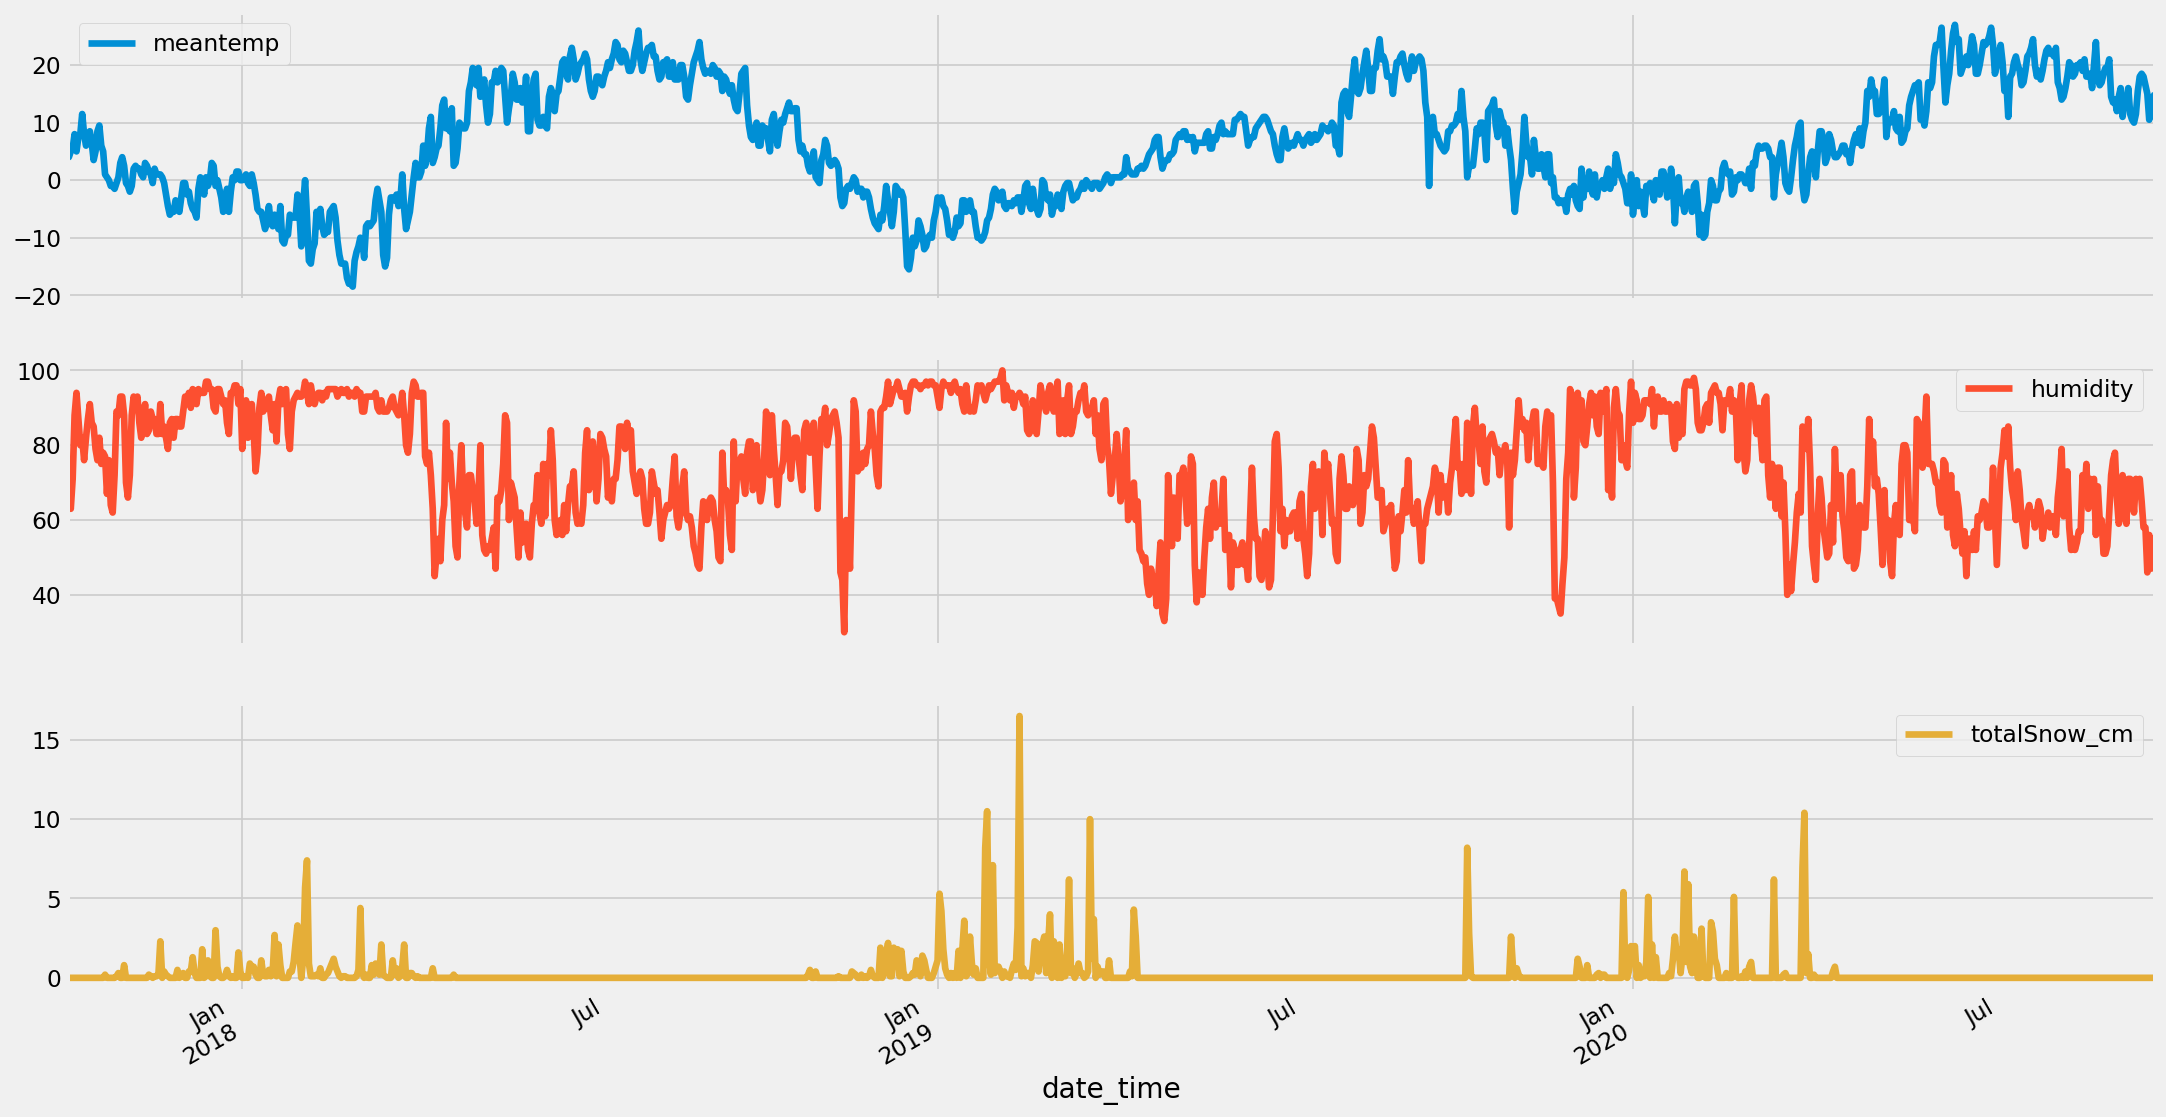

In [325]:
weather_df.plot(subplots=True, figsize=(20,12))

In [327]:
# функция для проверки скользящих среднего и отклонения
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [326]:
# расширенный Дики-Фуллер тест
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

In [332]:
# графики выше показывают, что средняя дневная температура 
# наиболее пригодна для построения достоверного и полезного прогноза
weather_df = weather_df[['meantemp']]

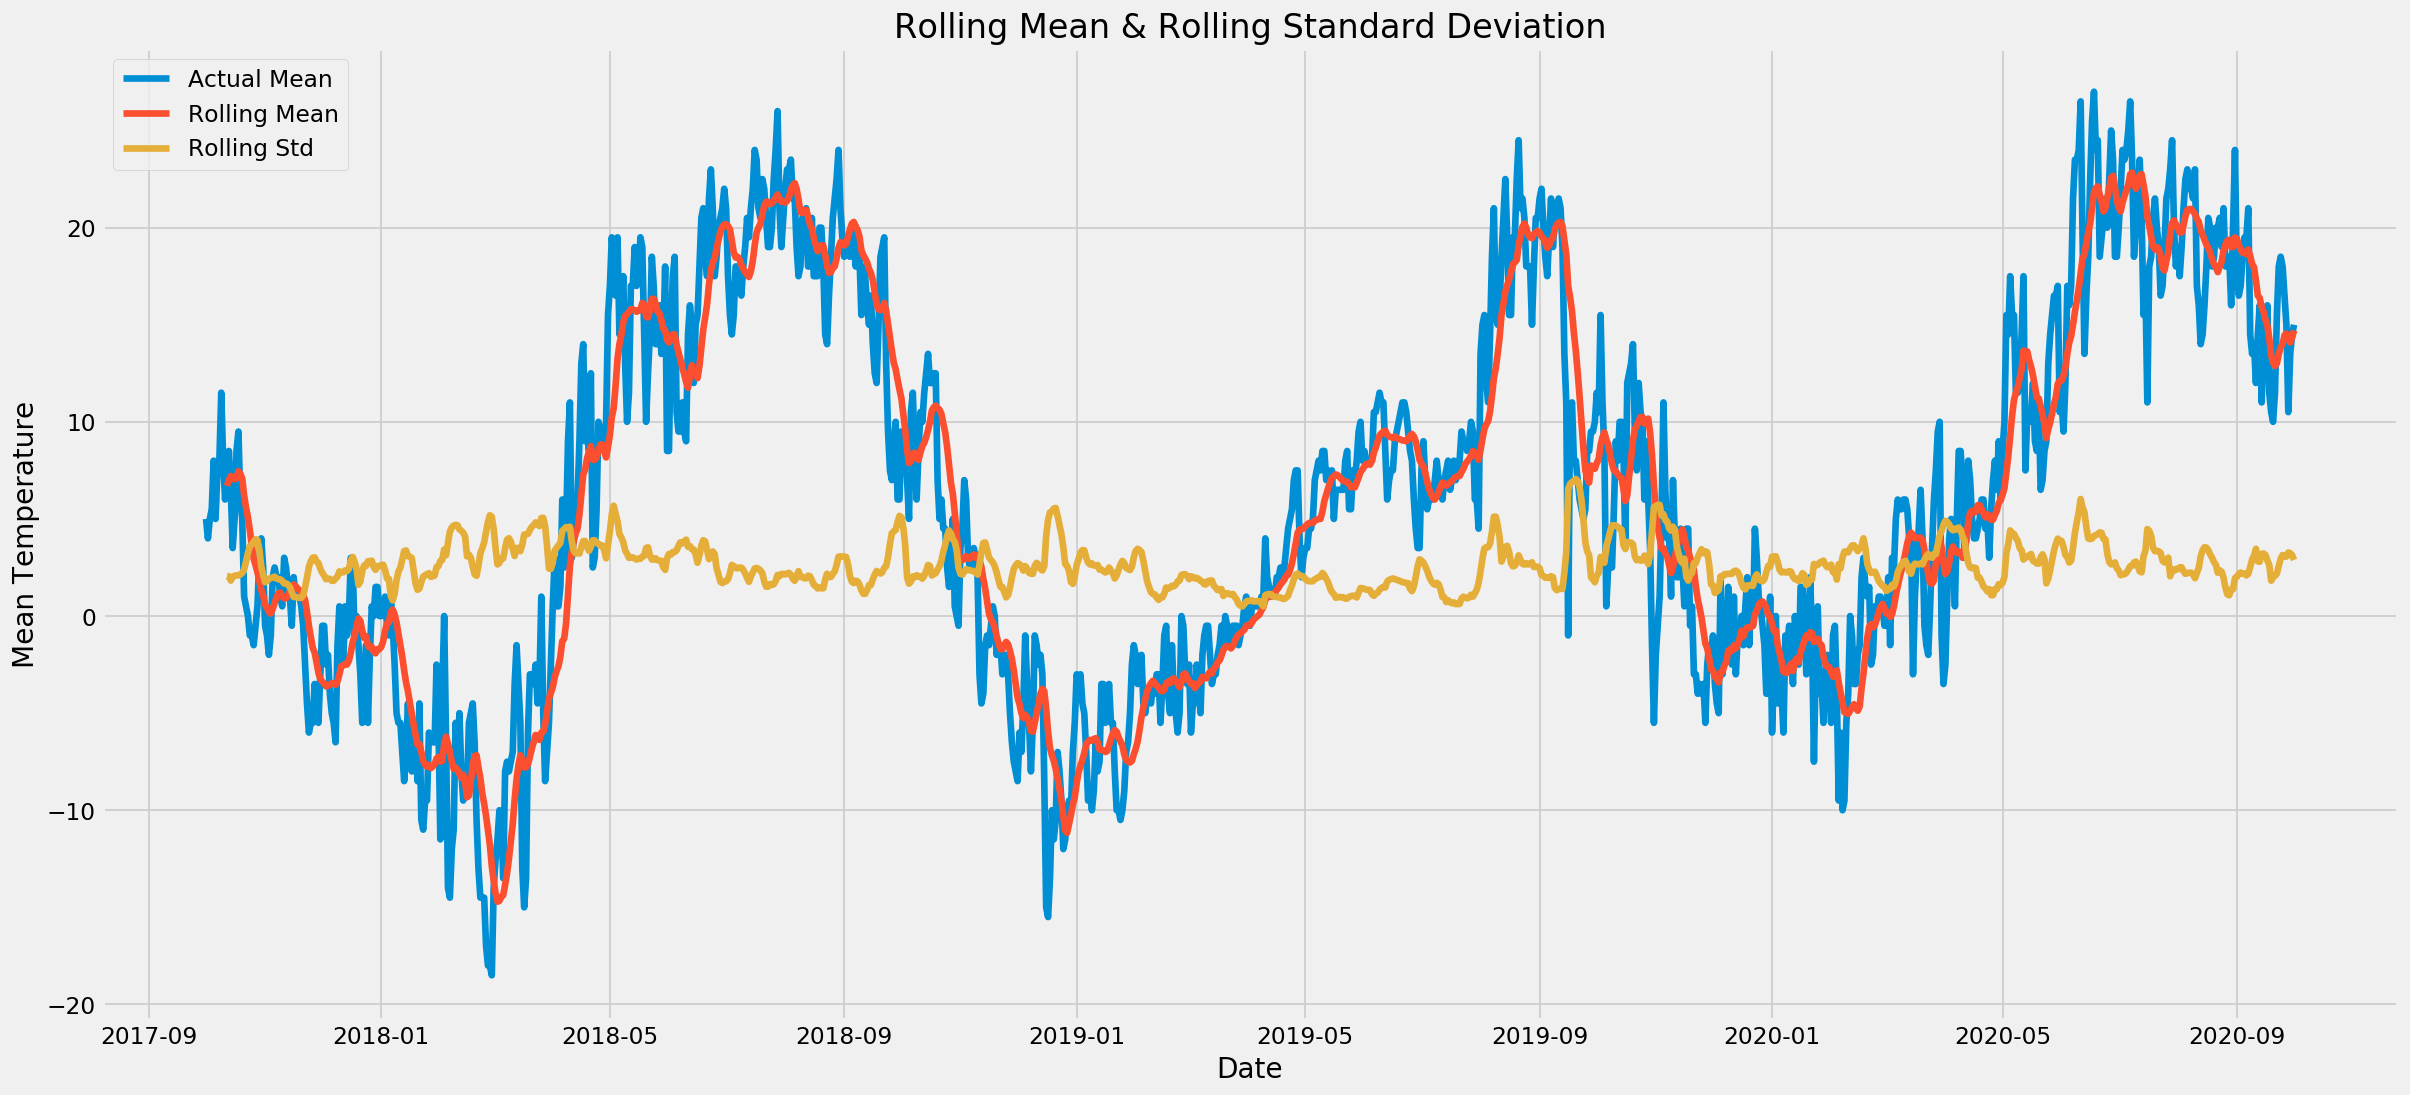

Test statistic:  -1.990116528298502
Critical Values: {'1%': -3.4363746281360426, '5%': -2.864200133611212, '10%': -2.568186343567528}


In [333]:
# проверяем отклонения и проводим тест
plot_rolling_mean_std(weather_df.meantemp)
perform_dickey_fuller_test(weather_df.meantemp)

Тестовое значение меньше критических значений - ряд стационарный. Этого достаточно, но если бы ряд не был стационарным, могли сделать его таким с помощью метода разностных операторов (приведен ниже).

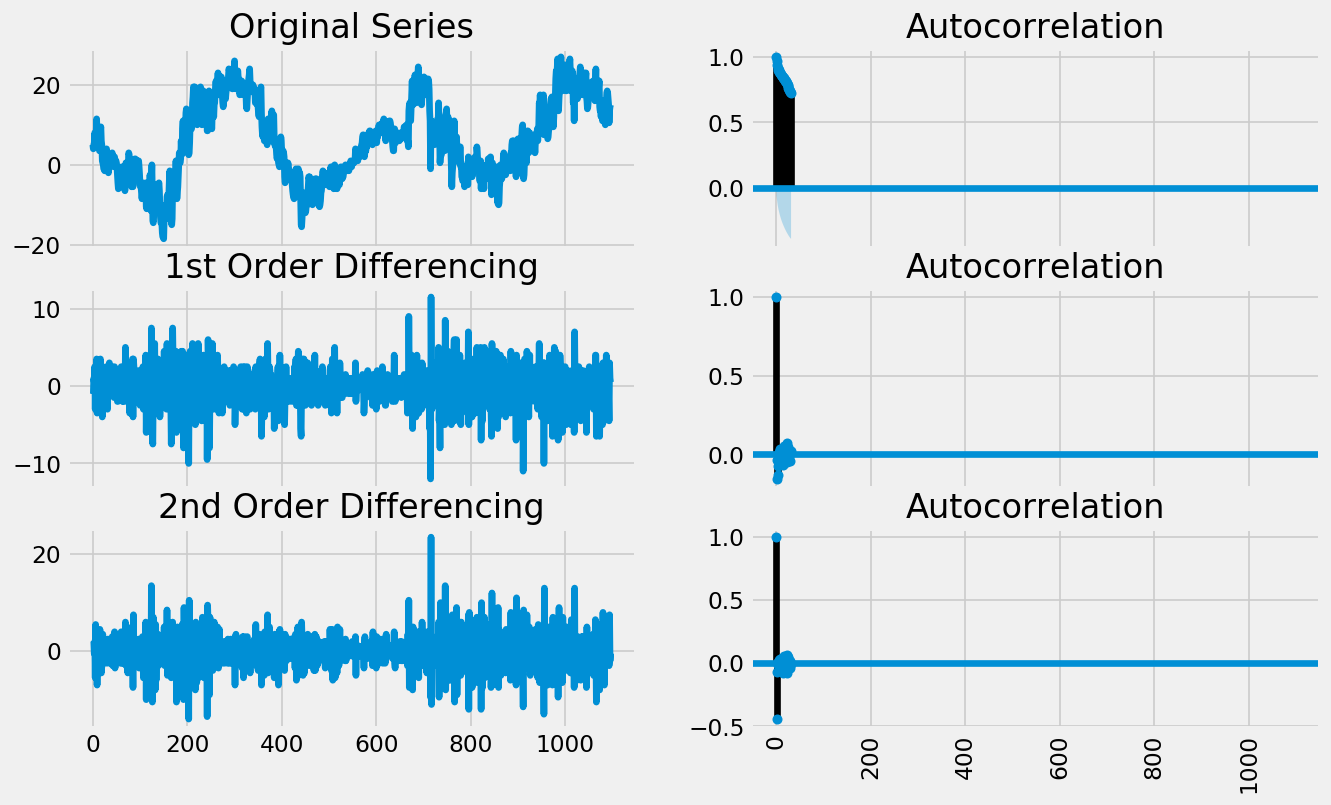

In [334]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(weather_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(weather_df.values, ax=axes[0, 1])

axes[1, 0].plot(weather_df.meantemp.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(weather_df.diff().dropna().values,ax=axes[1, 1])

axes[2, 0].plot(weather_df.meantemp.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(weather_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

В нашем случае разностного оператора первого порядка было бы достаточно для достижения стационарности. 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


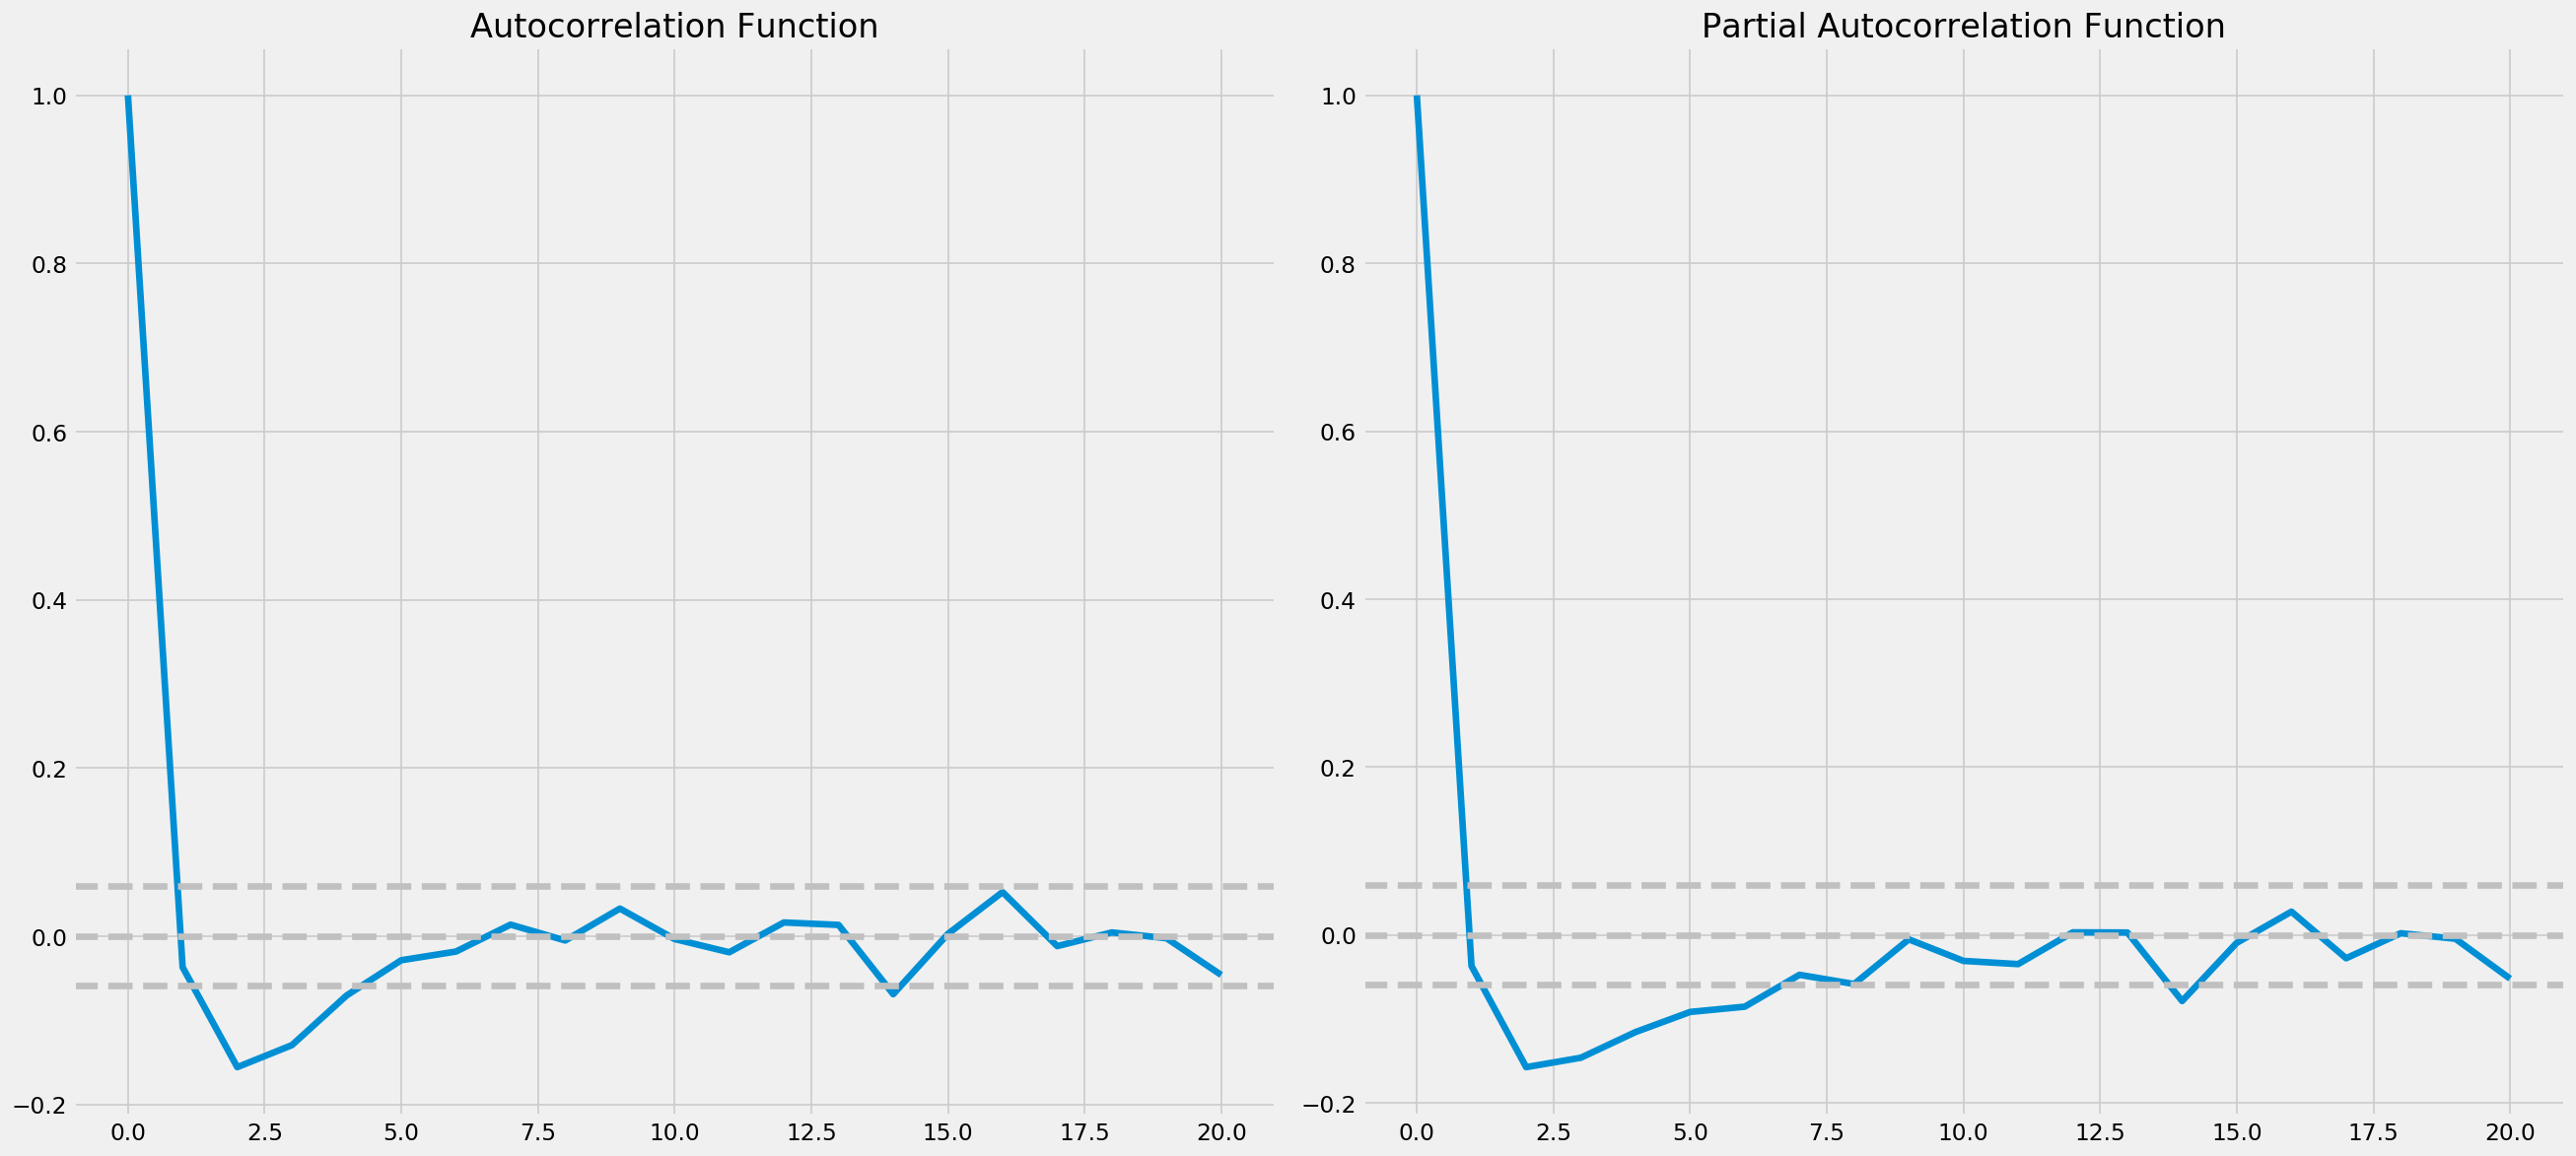

In [337]:
# Рассчитаем ACF и PACF
acf_lag = acf(weather_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(weather_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(weather_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(weather_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(weather_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(weather_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

#### Выберем параметры для нашей модели

p - точка, где PACF пересекает верхнюю границу доверительного интервала. Где-то около 1: p = 1.

q - точка, где ACF пересекает верхнюю границу доверительного интерва. q = 1.

d - количество несезонных отличий, нужных для стационарности. У нас их ноль, потому и d = 0

In [339]:
# Построение модели
model = ARIMA(weather_df.values, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1097
Model:                     ARMA(1, 1)   Log Likelihood               -2551.757
Method:                       css-mle   S.D. of innovations              2.474
Date:                Mon, 05 Oct 2020   AIC                           5111.514
Time:                        00:18:30   BIC                           5131.515
Sample:                             0   HQIC                          5119.081
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2796      2.239      2.805      0.005       1.891      10.668
ar.L1.y        0.9685      0.008    125.237      0.000       0.953       0.984
ma.L1.y       -0.0311      0.038     -0.820      0.4

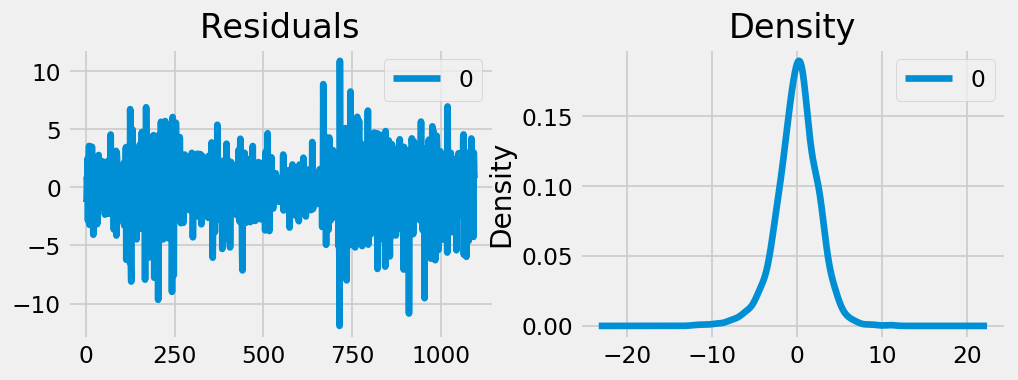

In [212]:
# Остаточные ошибки
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

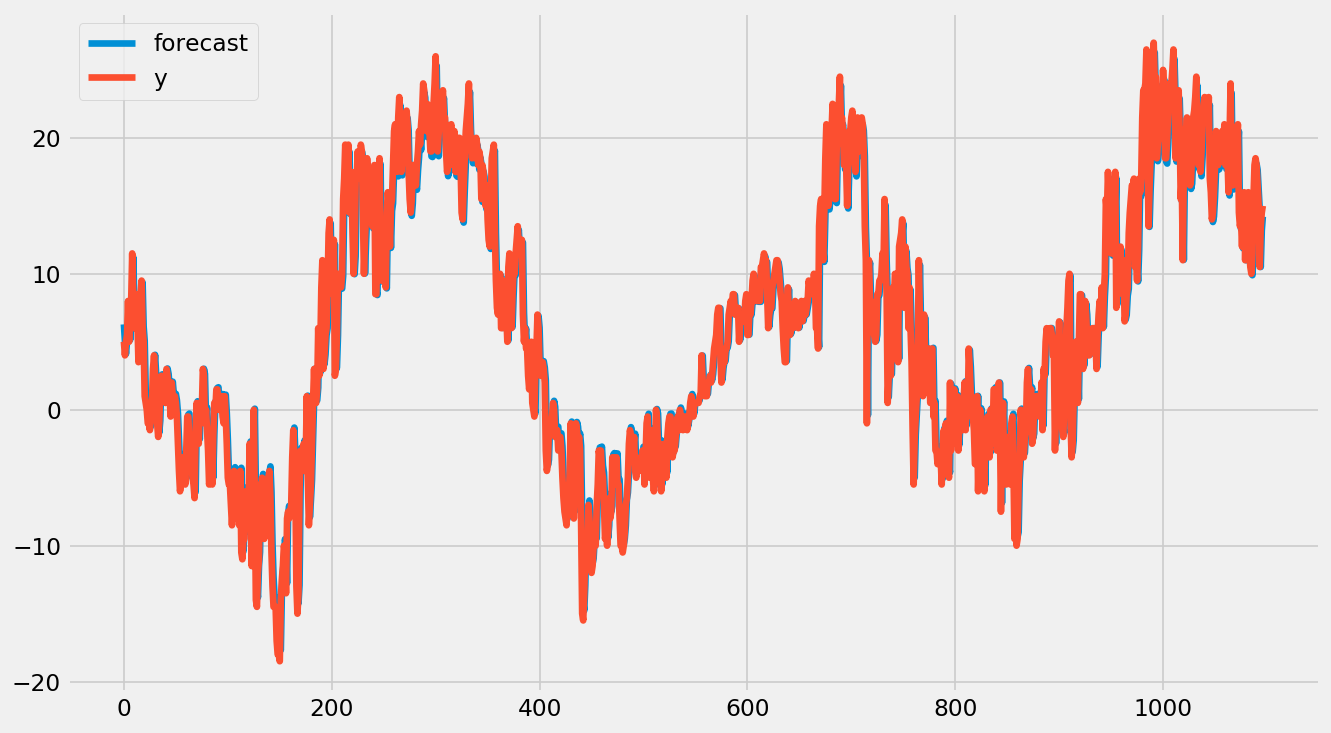

In [340]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [341]:
#создадим пустой датафрейм с временным рядом, необходимым для дальнейшего прогнозирования погоды 

rng = pd.date_range('2020-10-01', periods=61, freq='D')
meantemp = np.empty(61)
meantemp[:] = np.nan
dict_frame = {'date_time':rng, 'meantemp': meantemp}
forecast_df = pd.DataFrame(dict_frame)

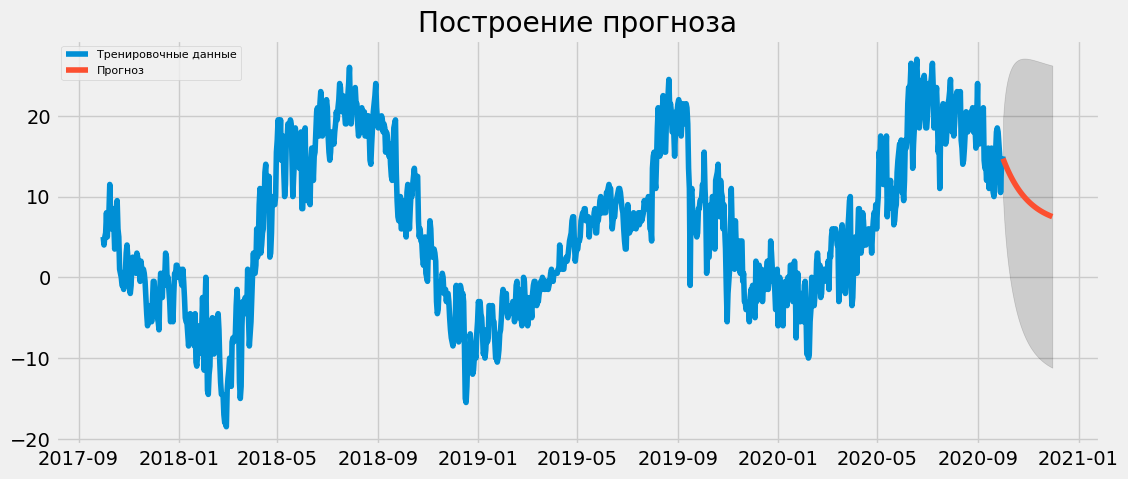

In [342]:
#Прогнозирование

fc, se, conf = model_fit.forecast(61, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=forecast_df.date_time)
lower_series = pd.Series(conf[:, 0], index=forecast_df.date_time)
upper_series = pd.Series(conf[:, 1], index=forecast_df.date_time)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(weather_df, label='Тренировочные данные')
plt.plot(fc_series, label='Прогноз')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Построение прогноза')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# test_df.index

In [343]:
weather_foreast = pd.DataFrame(fc_series)

(0, 15.05995200415716)

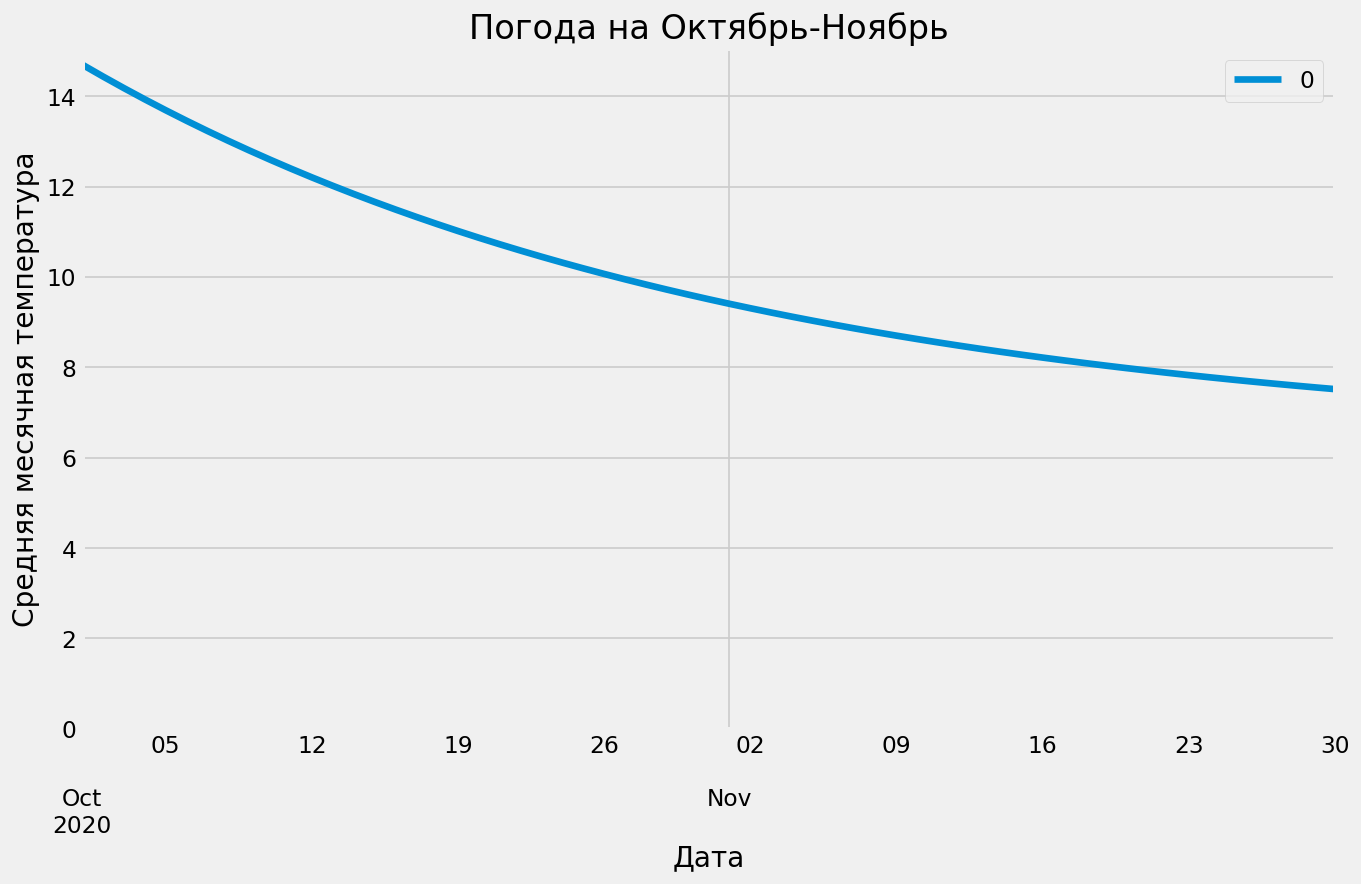

In [344]:
weather_foreast.plot()
plt.xlabel("Дата")
plt.ylabel("Средняя месячная температура")
plt.title('Погода на Октябрь-Ноябрь')
plt.ylim(bottom=0)
